## GIF of U.S. lakes, from least to most circular

Uses a representative subset of 300 natural lakes from the LAGOS-US LOCUS v1.0 dataset for 479,950 lakes.

Uses the variable shoreline development factor:
 > "is the ratio of the length of the lake's shoreline to the circumference of a circle with the same area as the lake."  https://en.wikipedia.org/wiki/Shoreline_development_index
 
 
**Data source:** Smith, N.J., K.E. Webster, L.K. Rodriguez, K.S. Cheruvelil, and P.A. Soranno. 2021. LAGOS-US LOCUS v1.0: Data module of location, identifiers, and physical characteristics of lakes and their watersheds in the conterminous U.S. ver 1. Environmental Data Initiative. https://doi.org/10.6073/pasta/e5c2fb8d77467d3f03de4667ac2173ca (Accessed 2022-04-06).

**Data URL:** 
https://portal.edirepository.org/nis/mapbrowse?packageid=edi.854.1

## Import packages

In [180]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
import cmasher as cmr
import imageio
import math
import statistics
import os

## Read in files

In [181]:
# Shapefile of lake polygons
lake_polys = gpd.read_file("gis_locus_v1.0.gdb", driver='FileGDB', layer=0)

In [182]:
# Table of lake information
lake_info = pd.read_csv('lake_information.csv')

In [183]:
# Table of lake characteristics
lake_chars = pd.read_csv('lake_characteristics.csv')

## Compile variables of interest into a single dataset

In [184]:
# Join selected attributes from lake_info and lake_chars to the lake_polys dataset
lakes = pd.merge(lake_polys, lake_info[['lagoslakeid','lake_nhdid','lake_namegnis','lake_lat_decdeg','lake_lon_decdeg','lake_ismultipart','lake_centroidstate','lake_nhdftype','lake_shapeflag']], on='lagoslakeid')
lakes = pd.merge(lakes, lake_chars[['lagoslakeid','lake_waterarea_ha','lake_shorelinedevfactor','lake_perimeter_m','lake_mbgconhull_length_m','lake_mbgrect_length_m']], on='lagoslakeid')

In [185]:
# Filter out reservoirs (nhd ftype == 390), multi-part lakes, and lakes with a 
# shape flag (which indicate that the lake may not be natural or is riverine)
lakes = lakes.loc[(lakes['lake_nhdftype']==390) & (lakes['lake_ismultipart'] == 'N') & (lakes['lake_shapeflag'] == 'noflag')]

## Find subset of 100 lakes that spans the observed shoreline development factors

In [186]:
# Sort lakes by shoreline development factor
lakes = lakes.sort_values(by='lake_shorelinedevfactor', ascending=True)

In [187]:
# Set up a series of the desired percentile values that we want to represent
n_percentiles = 101
desired_percentiles = np.linspace(0,1,n_percentiles)

In [188]:
# Compute values corresponding to those percentiles using the dataset
percentile_values = lakes['lake_shorelinedevfactor'].quantile(q=desired_percentiles).to_list()

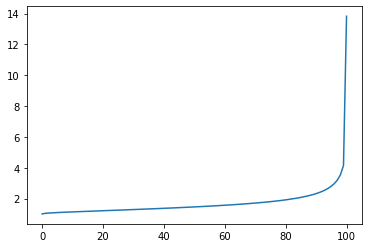

In [189]:
plt.plot(percentile_values)

In [190]:
len(percentile_values)

101

In [191]:
# drop the top percentile since it's so extreme (and a reservoir)
percentile_values = percentile_values[0:(n_percentiles-1)]

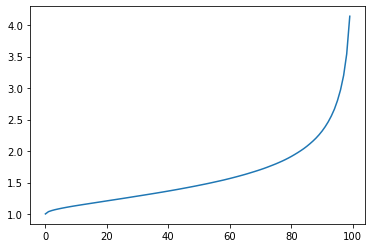

In [192]:
plt.plot(percentile_values)

In [193]:
# Find which actual values in the dataset are closest to those computed percentiles
indices_of_closest_rows = np.searchsorted(lakes['lake_shorelinedevfactor'],percentile_values)

In [194]:
# Subset the dataset to only those values
lake_subset = lakes.iloc[indices_of_closest_rows]

## Munge for plotting

In [195]:
# Re-sort the subset so that lake shoreline development factor is is descending order
lake_subset = lake_subset.sort_values(by='lake_shorelinedevfactor', ascending=False)
lake_subset.reset_index(inplace=True)

In [196]:
# Get centroid of each lake
lake_subset['centroid'] = lake_subset.centroid
lake_subset['centroid_lon'] = lake_subset.centroid.map(lambda p: p.x)
lake_subset['centroid_lat'] = lake_subset.centroid.map(lambda p: p.y)

In [197]:
# Compute radius and circumference for circle of same area as each lake
lake_subset['circle_radius'] = [math.sqrt(i/math.pi) for i in lake_subset['Shape_Area']]
lake_subset['circle_circumference'] = math.pi*lake_subset.circle_radius*2

In [198]:
# Log-transform lake shoreline development factors for lake chart color scale
lake_subset['log_sdf'] = [math.log(i) for i in lake_subset['lake_shorelinedevfactor']]

## Build GIF

In [199]:
# Store maximum SDF across all 100 lakes
max_sdf = max(lake_subset.lake_shorelinedevfactor)

In [202]:
# Create list to store image filenames
frame_file_list = []

# loop through the 100 lakes to...
for index, lake_id in enumerate(lake_subset.lagoslakeid.to_list()):

    ## Set up the figure parameters (two subplots in 1 column, with an uneven height ratio)
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7, 4.5), gridspec_kw={'height_ratios': [8, 1]})

    ## Subset dataframe to selected lake
    sel_lake = lake_subset.loc[lake_subset['lagoslakeid'] == lake_id]
    lake_sdf = sel_lake.lake_shorelinedevfactor.iloc[0]
    
    ## Add the lake polygon to the first subplot
    sel_lake.plot(ax=ax1, color='#68A4D6',edgecolor='#68A4D6',linewidth=0.5)
    
    ## Add a circle of the same area as the lake to the first subplot
    # Get bounding box and use to determine center for the circle
    sel_lake_bbox = sel_lake.bounds
    sel_lake_bbox['x_mid'] = statistics.mean([sel_lake_bbox.iloc[0].maxx,sel_lake_bbox.iloc[0].minx])
    sel_lake_bbox['y_mid'] = statistics.mean([sel_lake_bbox.iloc[0].maxy,sel_lake_bbox.iloc[0].miny])
    
    # add to plot
    circle1 = plt.Circle((sel_lake_bbox['x_mid'],sel_lake_bbox['y_mid']),sel_lake.circle_radius,edgecolor='black', facecolor='none', clip_on=False)
    ax1.add_patch(circle1)
    
    # In the second subplot, add a representing the range of shoreline development factor
    x1, y1 = [1, max_sdf], [0,0]
    ax2.plot(x1, y1, color='black')
    
    # Add annotations to second subplot
    plt.xlim(0.7,max_sdf+0.7)
    plt.ylim(-1,1)
    ax2.plot(lake_sdf, 0,'bo', markersize=8, color='#68A4D6')
    ax2.annotate('Perfect circle', xy=(20,50), xycoords='figure points', color='black')
    ax2.annotate('Complex shape', xy=(395,50), xycoords='figure points', color='black')
    
    # style plots
    ax1.axis('off')
    plt.axis('off')

    # Add title and data source
    plt.annotate('100 U.S. lakes - from least to most circular', xy=(20,300), xycoords='figure points' ,color = 'black', fontsize=15)
    plt.annotate('Data from LAGOS-US LOCUS v1.0, Smith et al., 2021 — GIF by H. Corson-Dosch, USGS', xy=(20,5), xycoords='figure points' ,color = 'silver', fontsize=9, fontstyle='italic')
    
    # define filename
    out_file = f'lake_gif/{lake_id}.png'
    
    # Add image to the file list, w/ variable # of frames depending
    # on where the lake falls in the line up
    # for first image, repeat for 40 frames
    if (index==0):
        ax1.annotate('circle of same area as lake', xy=(-0.15,0.3), xycoords='axes fraction')
        for i in range(40):
            frame_file_list.append(out_file)
    # For last image, add annotation with lake name and repeat for 25 frames
    elif ((index==len(lake_subset.lagoslakeid.to_list())-1) & (lake_id==39187)):
        ax1.annotate('Big Oak Lake, Missouri', xy=(-0.60,0.55), xycoords='axes fraction')
        for i in range(25):
            frame_file_list.append(out_file)
    # Otherwise repeat for 3 frames
    else:
        for i in range(3):
            frame_file_list.append(out_file)
            
    # save figure
    plt.savefig(out_file)
    
    # Close plot
    plt.close()

In [204]:
# Write gif using specified file/frame order
with imageio.get_writer('lake_sdf.gif', mode='I') as writer:
    for filename in frame_file_list:
        image = imageio.imread(filename)
        writer.append_data(image)

In [205]:
# Remove files
for filename in set(frame_file_list):
    os.remove(filename)

## Build composite chart of all 100 lake polygons

In [85]:
# Store min and max values of log-transformed shoreline development factor
min_log_sdf = min(lake_subset.log_sdf)
max_log_sdf = max(lake_subset.log_sdf)

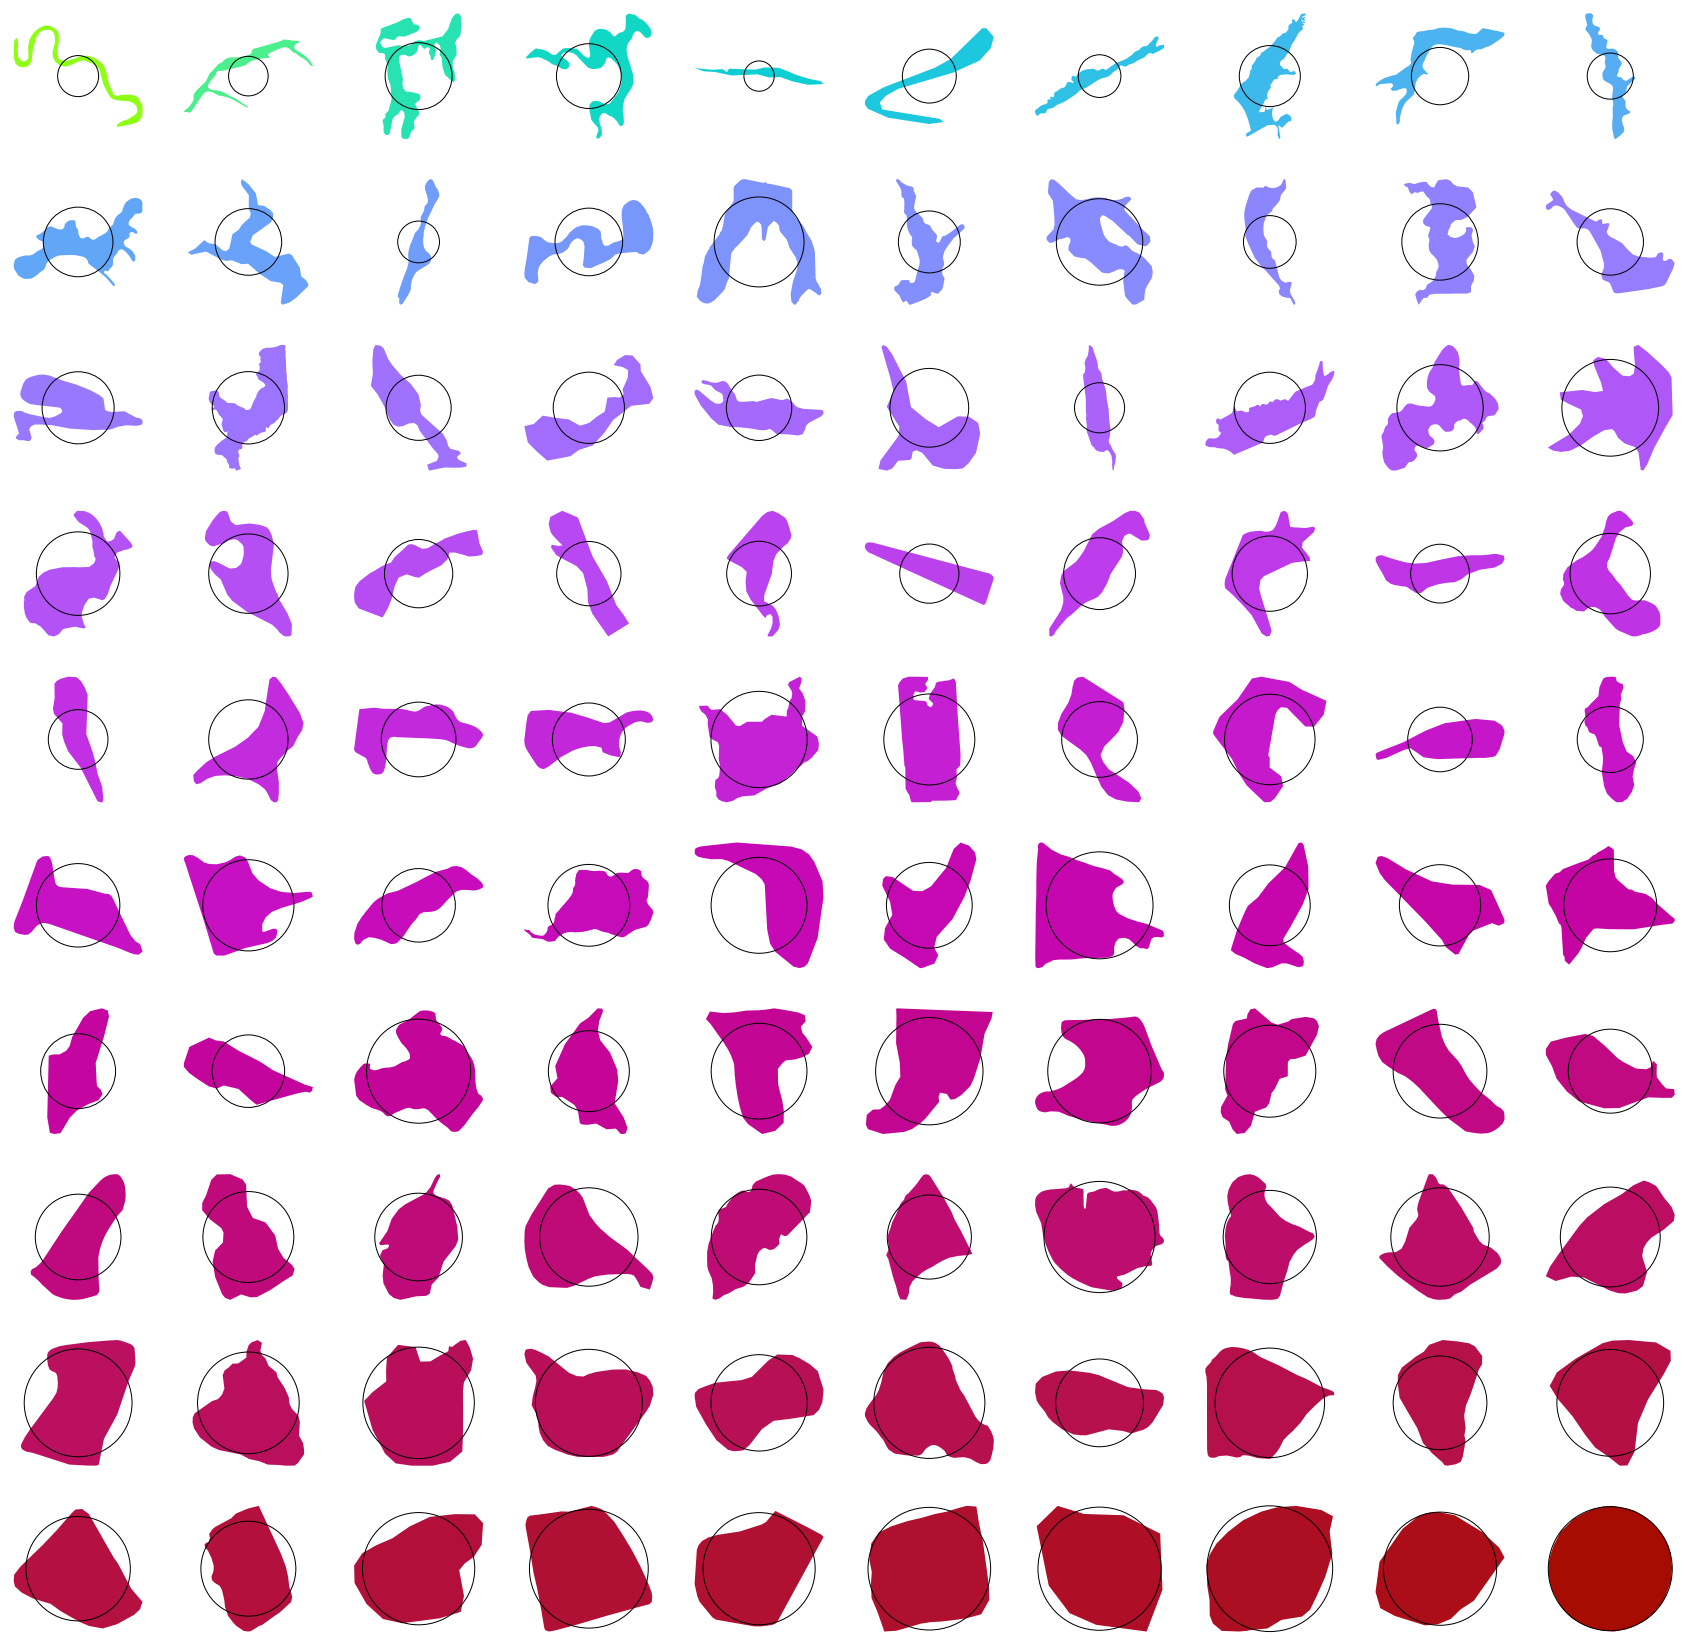

In [87]:
# Set up chart columns and rows
n_rows, n_cols = 10, 10
n_plots = 100
fig = plt.figure(figsize=(30, 30))

for i in range(n_plots):
    sel_lake = lake_subset.iloc[[i]]
    ax = fig.add_subplot(n_rows,n_cols,i+1)
    
    # plot lake
    sel_lake.plot(ax=ax, column='log_sdf', vmin=min_log_sdf, vmax = max_log_sdf, cmap=cmr.neon)
    
    # Get bounding box and use to determine circle radius
    sel_lake_bbox = sel_lake.bounds
    sel_lake_bbox['x_mid'] = statistics.mean([sel_lake_bbox.iloc[0].maxx,sel_lake_bbox.iloc[0].minx])
    sel_lake_bbox['y_mid'] = statistics.mean([sel_lake_bbox.iloc[0].maxy,sel_lake_bbox.iloc[0].miny])
    
    # circle of same area
    circle1 = plt.Circle((sel_lake_bbox['x_mid'],sel_lake_bbox['y_mid']),sel_lake.circle_radius,edgecolor='black', facecolor='none', clip_on=False)
    ax.add_patch(circle1)
    ax.axis('off')
    
plt.savefig('lakes.png', bbox_inches='tight', dpi=300)

In [53]:
# Pull out named lakes, for labelling
lake_subset.loc[lake_subset['lake_namegnis'].notna()]

,index,lagoslakeid,Shape_Length,Shape_Area,geometry,lake_nhdid,lake_namegnis,lake_lat_decdeg,lake_lon_decdeg,lake_ismultipart,...,lake_totalarea_ha,lake_shorelinedevfactor,lake_perimeter_m,lake_mbgconhull_length_m,lake_mbgrect_length_m,centroid,centroid_lon,centroid_lat,circle_radius,circle_circumference
7,130047,242355,5292.082316,366713.011400,"MULTIPOLYGON (((858656.273 1187238.660, 858655...",90883185,Lunker Lake,33.377091,-86.694508,N,...,36.671301,2.465236,5292.082310,1528.824697,1460.105162,POINT (858867.489 1187680.591),8.588675e+05,1.187681e+06,341.655348,2146.683864
12,451787,455269,2401.982555,98605.606680,"MULTIPOLYGON (((-1236311.504 2089301.222, -123...",46848315,Grassy Lake,40.941805,-110.865731,N,...,9.860561,2.157814,2401.982546,1098.093891,1098.084634,POINT (-1236416.151 2089417.252),-1.236416e+06,2.089417e+06,177.164160,1113.155244
26,417124,420606,1049.303369,28305.513783,"MULTIPOLYGON (((27452.247 925440.066, 27455.89...",93989812,Zeke Lake,31.401759,-95.709946,N,...,2.830551,1.759383,1049.303412,484.208176,483.971191,POINT (27480.632 925204.790),2.748063e+04,9.252048e+05,94.920624,596.403870
27,301350,127091,3579.535390,336533.974868,"MULTIPOLYGON (((309679.803 2749479.941, 309507...",81003465,Argo Lake,47.680236,-91.906775,N,...,33.653397,1.740633,3579.535484,1365.936443,1364.804845,POINT (309418.776 2749544.121),3.094188e+05,2.749544e+06,327.295113,2056.455847
33,205922,274528,735.156250,15899.100474,"MULTIPOLYGON (((925434.346 1407640.074, 925460...",139322603,Grundy Lake Number Two,35.274208,-85.719053,N,...,1.589910,1.644706,735.156238,295.834747,294.373730,POINT (925514.824 1407521.259),9.255148e+05,1.407521e+06,71.139587,446.983209
36,462646,466128,752.137326,17516.380236,"MULTIPOLYGON (((-1679476.050 2835213.545, -167...",43937891,Hooper Lake,46.740831,-118.093780,N,...,1.751638,1.603135,752.137303,317.623617,316.311819,POINT (-1679574.229 2835121.207),-1.679574e+06,2.835121e+06,74.670188,469.166629
53,10961,122428,4677.283321,865220.012319,"MULTIPOLYGON (((2020491.699 2398611.403, 20205...",135696467,Ponkapoag Pond,42.192375,-71.095013,N,...,86.522001,1.418487,4677.283287,1701.458483,1665.477978,POINT (2019893.720 2398627.586),2.019894e+06,2.398628e+06,524.793372,3297.374006
61,8492,83074,580.284873,14733.705761,"MULTIPOLYGON (((1935060.738 2282864.923, 19350...",123015076,Rogers Pond,41.382027,-72.442535,N,...,1.473371,1.348591,580.284894,247.730996,244.142293,POINT (1935164.315 2282847.372),1.935164e+06,2.282847e+06,68.482729,430.289678
73,443935,447417,552.813017,15459.382491,"MULTIPOLYGON (((-917027.293 1614682.544, -9170...",133158220,Waterdog Lake,37.121122,-106.439243,N,...,1.545938,1.254230,552.812994,204.551500,204.245369,POINT (-916991.936 1614743.894),-9.169919e+05,1.614744e+06,70.148944,440.758811
85,466029,469511,1394.646316,114268.548527,"MULTIPOLYGON (((-2063267.965 3073656.392, -206...",123451890,Sol Duc Lake,47.926311,-123.781498,N,...,11.426855,1.163847,1394.646287,486.605106,479.716039,POINT (-2063114.022 3073760.960),-2.063114e+06,3.073761e+06,190.716566,1198.307527
